In [1]:
!pip -qq install -U langchain langchain-community langgraph pydantic google-ai-generativelanguage==0.6.15 langchain-google-genai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.6/90.6 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.1/75.1 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 41.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 64.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 117.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 450.8/450.8 kB 38.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.4/155.4 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 463.6/463.6 kB 42.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 96.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.4/155.4 kB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/

In [2]:
import os
import operator
from typing import Annotated, Literal
from typing_extensions import TypedDict
from pydantic import BaseModel

from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.prebuilt import ToolNode
from langgraph.graph.message import add_messages
from langgraph.types import Command

from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.chat_models import init_chat_model
from langchain_core.messages import AnyMessage, HumanMessage

from google.colab import userdata

from getpass import getpass
import os

# Enter the key securely (won't be visible when typed)
os.environ['API_KEY'] = getpass('Enter your API key: ')

# Use the key
GOOGLE_API_KEY = os.environ['API_KEY']


Enter your API key: ··········


**Prompt Chaining**: Prompt chaining in LangChain refers to the technique of linking multiple prompts and Large Language Model (LLM) calls in a sequential manner, where the output of one step serves as the input for the next.

In [3]:
# Define LLM client
llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
    api_key=GOOGLE_API_KEY,
    system_instruction="""You are an expert technical writer. Always give clear,
     concise, and straight-to-the-point answers."""
)

# Define the graph state
class State(dict):
    text: str
    topics: str
    title: str

# Define nodes (steps)
def extract_topics(state: State) -> State:
    prompt = f"Extract 1-3 key topics from the following text:\n\n{state['text']}"
    resp = llm.invoke(prompt)
    state["topics"] = resp.content.strip()
    return state

def generate_title(state: State) -> State:
    prompt = f"Generate two catchy blog titles for each one these topics:\n\n{state['topics']}"
    resp = llm.invoke(prompt)
    state["title"] = resp.content.strip()
    return state

# Build the graph
workflow = StateGraph(State)
workflow.add_node("extract_topics", extract_topics)
workflow.add_node("generate_title", generate_title)

# Flow: extract_topics → generate_title → END
workflow.set_entry_point("extract_topics")
workflow.add_edge("extract_topics", "generate_title")
workflow.add_edge("generate_title", END)

# Compile runnable graph
graph = workflow.compile()

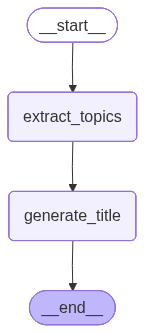

In [4]:
graph

In [7]:
# Run the graph
input_text = (
    "LlamaIndex agents are AI-powered reasoning and decision engines designed to automate complex tasks, especially those involving your private or domain-specific data. "
    "LlamaIndex is highly regarded for its data-centric approach and strong features for Retrieval-Augmented Generation (RAG) when compared to other frameworks like LangChain or CrewAI. "
)

result = graph.invoke({"text": input_text})
print("Topics:", result["topics"])
print("\n"+"="*50+"\n")
print("Suggested Blog Title:", result["title"])

Topics: Here are 3 key topics from the text:

1.  **LlamaIndex Agents:** The core subject, highlighting their purpose as AI reasoning and decision engines.
2.  **Automation of Complex Tasks:** What LlamaIndex agents are designed to do.
3.  **Data-Centric RAG:** LlamaIndex's strength and focus, especially in comparison to other frameworks.


Suggested Blog Title: Okay, here are two catchy blog titles for each of the three topics you provided:

**1. LlamaIndex Agents:**

*   **Title 1:** LlamaIndex Agents: Your AI Reasoning Powerhouse
*   **Title 2:** Unleash the Power of AI Decision-Making with LlamaIndex Agents

**2. Automation of Complex Tasks:**

*   **Title 1:** Tame the Chaos: Automating Complex Tasks with LlamaIndex
*   **Title 2:** From Tedious to Triumphant: LlamaIndex Automates Your Toughest Tasks

**3. Data-Centric RAG:**

*   **Title 1:** LlamaIndex: Where RAG Meets Data Mastery
*   **Title 2:** Beyond the Buzz: Why LlamaIndex's Data-Centric RAG is a Game Changer


**Routing**: Routing in LangChain provides a mechanism to intelligently direct user inputs to the most appropriate chain, tool, or model within an LLM-powered application. This enables the creation of more sophisticated, efficient, and specialized AI systems.

In [10]:
# LLM client
llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
    api_key=GOOGLE_API_KEY,
    system_instruction="""You are a helpful assistant that can classify text
    sentiment and respond accordingly."""
)

# State definition
class State(dict):
    text: str
    sentiment: str
    response: str

# Nodes
def classification(state: State) -> str:
    """Classify sentiment."""
    prompt = f"Is the following text positive or negative? Answer with one word only: Positive or Negative.\n\n{state['text']}"
    resp = llm.invoke(prompt)
    sentiment = resp.content.strip().lower()
    state["sentiment"] = sentiment
    return state

def positive_node(state: State) -> State:
    prompt = f"Generate an encouraging reply to this positive text:\n\n{state['text']}"
    resp = llm.invoke(prompt)
    state["response"] = resp.content.strip()
    return state

def negative_node(state: State) -> State:
    prompt = f"Generate a supportive reply to this negative text:\n\n{state['text']}"
    resp = llm.invoke(prompt)
    state["response"] = resp.content.strip()
    return state

def router_func(state: State) -> Literal["positive", "negative"]:
    """Return next node name."""
    return "positive" if "positive" in state["sentiment"] else "negative"

# Build the graph
workflow = StateGraph(State)

workflow.add_node("classification", classification)
workflow.add_node("positive", positive_node)
workflow.add_node("negative", negative_node)

# classify node decides the next step
workflow.set_entry_point("classification")
workflow.add_conditional_edges("classification", router_func, {
    "positive": "positive",
    "negative": "negative",
})

# Both branches lead to END
workflow.add_edge("positive", END)
workflow.add_edge("negative", END)

graph = workflow.compile()

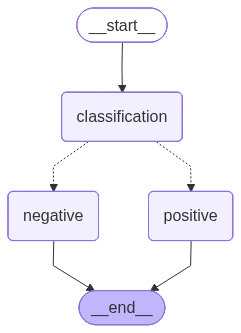

In [11]:
graph

In [12]:
# Run example
input_text = "I am very excited to learn and explore the world of AI"
result = graph.invoke({"text": input_text})
print("Sentiment:", result["sentiment"])
print("Response:", result["response"])


Sentiment: positive
Response: That's fantastic! The world of AI is truly fascinating and full of incredible potential. I'm excited for you too! Dive in, ask lots of questions, and have fun exploring! You're embarking on a really rewarding journey. Good luck!


**Parallelization**: Parallelization in LangChain refers to the ability to execute multiple components or chains concurrently, rather than sequentially. This significantly improves efficiency, especially when dealing with tasks that can operate independently or when minimizing latency is crucial.

In [13]:
# LLM client
llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    api_key=GOOGLE_API_KEY,
)

# State definition
class State(TypedDict):
    text: str
    # Reducer makes these append-only so multiple nodes can update in parallel
    outputs: Annotated[list, operator.add]

# Nodes
def summarize(state: State):
    prompt = f"Summarize in one sentence:\n\n{state['text']}"
    resp = llm.invoke(prompt)
    return {"outputs": [f"Summary: {resp.content.strip()}"]}

def critique(state: State):
    prompt = f"Critique briefly:\n\n{state['text']}"
    resp = llm.invoke(prompt)
    return {"outputs": [f"Critique: {resp.content.strip()}"]}

def combine(state: State):
    prompt = f"Combine the following Critique and Summarization in one \
    paragraph:\n\n{state['text']}"
    resp = llm.invoke(prompt)
    return {"outputs": [f"Combined:\n{resp.content.strip()}"]}

# Build the graph
builder = StateGraph(State)
builder.add_node("summarize", summarize)
builder.add_node("critique", critique)
builder.add_node("combine", combine)

# Parallel edges: summarize and critique run side by side
builder.add_edge(START, "summarize")
builder.add_edge(START, "critique")

# Both join into combine
builder.add_edge("summarize", "combine")
builder.add_edge("critique", "combine")

builder.add_edge("combine", END)

graph = builder.compile()

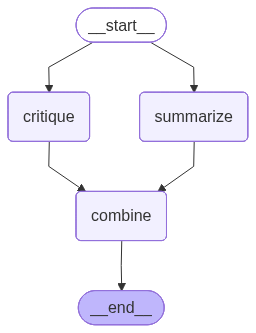

In [14]:
graph

In [15]:
# --- Run example ---
input_text = "Agentic AI architecture provides the structural framework for creating autonomous, goal-oriented AI systems that can reason, plan, and execute multi-step tasks with minimal human intervention."
result = graph.invoke({"text": input_text, "outputs": []})

print("\nFinal outputs:")
for out in result["outputs"]:
    print(out)
    print("="*100 + "\n")


Final outputs:
Critique: This is a **strong, concise, and accurate** definition.

**Strengths:**
*   **Clarity:** Easy to understand and follow.
*   **Completeness:** Effectively captures the core purpose (autonomous, goal-oriented systems) and key capabilities (reasoning, planning, execution) of agentic AI.
*   **Accuracy:** Correctly identifies the goal of "minimal human intervention."

**Minor Suggestion:**
*   The phrase "provides the structural framework for creating" could be slightly tightened, perhaps to "enables the creation of" or "is designed to create." However, this is a very minor stylistic point and doesn't detract from the overall clarity.

Summary: Agentic AI architecture provides the structural framework for autonomous, goal-oriented AI systems capable of independently reasoning, planning, and executing complex tasks.

Combined:
Agentic AI architecture describes the foundational framework for developing autonomous, goal-oriented AI systems capable of reasoning, plann

**Reflection**: Reflection is a prompting strategy used to improve the quality and success rate of agents and similar AI systems.

In [16]:
# LLM client
llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    api_key=GOOGLE_API_KEY,
)

# State
class State(TypedDict):
    task: str
    draft: str
    feedback: str
    final: str

# Nodes
def generator(state: State):
    """Generate an initial or refined draft."""
    prompt = f"""
You are an assistant helping to complete the following task:

Task:
{state['task']}

Current Draft:
{state.get('draft', 'None')}

Feedback:
{state.get('feedback', 'None')}

Instructions:
- If there is no draft and no feedback, generate a clear and complete response to the task.
- If there is a draft but no feedback, improve the draft as needed for clarity and quality.
- If there is both a draft and feedback, revise the draft by incorporating the feedback directly.
- Always produce a single, improved draft as your output.
"""
    resp = llm.invoke(prompt)
    return {"draft": resp.content.strip()}

def evaluator(state: State):
    """Evaluate the draft and give feedback or approval."""
    prompt = f"""Evaluate the following draft, based on the given task.
If it meets the requirements, reply exactly 'APPROVED'.
Otherwise, provide constructive feedback for improvement.
Task:
{state['task']}
Draft:
{state['draft']}"""
    resp = llm.invoke(prompt)
    print(f"""
================= DRAFT =================
{state['draft']}

================ FEEDBACK ===============
{resp.content.strip()}
========================================
""")
    return {"feedback": resp.content.strip()}

def decide(state: State) -> str:
    """Decide next step: either approve and finish, or refine again."""
    if "APPROVED" in state["feedback"].upper():
        return "approved"
    return "refine"

def finalize(state: State):
    """Save the final approved draft."""
    return {"final": state["draft"]}

# Build the graph
builder = StateGraph(State)

builder.add_node("generator", generator)
builder.add_node("evaluator", evaluator)
builder.add_node("finalize", finalize)

builder.add_edge(START, "generator")
builder.add_edge("generator", "evaluator")
builder.add_edge("evaluator", "finalize")

# Conditional edges from decide
builder.add_conditional_edges(
    "evaluator",
    decide,
    {
        "approved": "finalize",   # stop loop
        "refine": "generator",    # go back for improvement
    },
)

builder.add_edge("finalize", END)

graph = builder.compile()

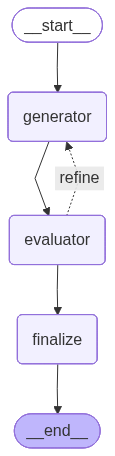

In [17]:
graph

In [18]:
# Run example
input_task = "You have six horses and want to race them to see which is fastest. What is the best way to do this?"
result = graph.invoke({"task": input_task})

print("\nFinal Answer:\n", result["final"])


================= DRAFT =================
To determine which of six horses is fastest, the best way is to:

1.  **Organize a single race** with all six horses competing simultaneously on the same track.
2.  **Observe the results.** The horse that crosses the finish line first is the fastest.

This method is the most direct and efficient, as it allows for a head-to-head comparison of all horses in a single event.

================ FEEDBACK ===============
APPROVED


Final Answer:
 To determine which of six horses is fastest, the best way is to:

1.  **Organize a single race** with all six horses competing simultaneously on the same track.
2.  **Observe the results.** The horse that crosses the finish line first is the fastest.

This method is the most direct and efficient, as it allows for a head-to-head comparison of all horses in a single event.


**Tool Use**: LangChain's tool usage involves providing external functionalities to Language Model (LLM) agents, enabling them to interact with the environment and perform specific tasks beyond their inherent capabilities.

In [19]:
# State definition
class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

# Define a simple tool
def calculator(expression: str):
    """Evaluate a math expression."""
    try:
        return str(eval(expression))
    except Exception as e:
        return f"Error: {e}"

# Initialize Gemini model with tools
llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    api_key=GOOGLE_API_KEY,
)

model_with_tools = llm.bind_tools([calculator])
tool_node = ToolNode([calculator])

# Nodes
def call_model(state: State):
    """Call the model; it may request a tool."""
    messages = state["messages"]
    response = model_with_tools.invoke(messages)
    return {"messages": [response]}

def should_continue(state: State):
    """Decide whether to go to tools or finish."""
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:  # If the model requested a tool
        return "tools"
    return END

# Build the graph
builder = StateGraph(State)

builder.add_node("call_model", call_model)
builder.add_node("tools", tool_node)

builder.add_edge(START, "call_model")
builder.add_conditional_edges("call_model", should_continue, ["tools", END])
builder.add_edge("tools", "call_model")

graph = builder.compile()

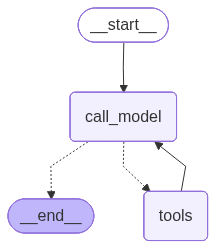

In [20]:
graph

In [21]:
# Run example
query = {"role": "user", "content": "What is ((((9+5)-56)*50)/2)"}
result = graph.invoke({"messages": [query]})

print("\nConversation:")
for m in result["messages"]:
    print(m)


Conversation:
content='What is ((((9+5)-56)*50)/2)' additional_kwargs={} response_metadata={} id='39852b26-ab14-47e4-8ab5-9ed566c0feaa'
content='' additional_kwargs={'function_call': {'name': 'calculator', 'arguments': '{"expression": "((((9+5)-56)*50)/2)"}'}} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []} id='run--05938a13-21fa-4fc8-b3aa-1ac69a7b2832-0' tool_calls=[{'name': 'calculator', 'args': {'expression': '((((9+5)-56)*50)/2)'}, 'id': 'bd84697d-9a05-4cf3-93c2-89394c4beab3', 'type': 'tool_call'}] usage_metadata={'input_tokens': 52, 'output_tokens': 25, 'total_tokens': 129, 'input_token_details': {'cache_read': 0}}
content='-1050.0' name='calculator' id='3bc05703-67bb-4afd-a304-e4879e8ee6b1' tool_call_id='bd84697d-9a05-4cf3-93c2-89394c4beab3'
content='The answer is -1050.' additional_kwargs={} response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'sa

**Planning**: Planning in LangChain refers to the process by which an AI agent, powered by a Large Language Model (LLM), determines the sequence of actions necessary to achieve a given objective. This is a fundamental aspect of building sophisticated and autonomous agents within the LangChain framework.

In [22]:
# Set up the Language Model
llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
    api_key=GOOGLE_API_KEY,
)

# Define the State
# We need separate fields for each worker's results.
class PlannerState(TypedDict):
    task: str
    plan: list[str]
    graphql_results: str  # Results from the GraphQL researcher
    rest_results: str     # Results from the REST researcher
    final_output: str     # The final written summary

# Define the Tools and Workers

# Dummy tools for our researchers
def graphql_search_tool(query: str):
    """A dummy tool that returns fixed info about GraphQL."""
    print(f"GRAPHQL RESEARCHER: Searching for '{query}'")
    return "GraphQL Pros: Efficient data fetching (no over-fetching), single endpoint, strongly typed schema."

def rest_search_tool(query: str):
    """A dummy tool that returns fixed info about REST."""
    print(f"REST RESEARCHER: Searching for '{query}'")
    return "REST API Cons: Can lead to over or under-fetching data, requires multiple round-trips for complex queries, URL-based structure can be rigid."

# Worker Nodes
def graphql_research_worker(state: PlannerState):
    """Worker node that researches GraphQL pros."""
    results = graphql_search_tool("pros of GraphQL")
    return {"graphql_results": results}

def rest_research_worker(state: PlannerState):
    """Worker node that researches REST cons."""
    results = rest_search_tool("cons of REST APIs")
    return {"rest_results": results}

def writer_worker(state: PlannerState):
    """
    Synthesizer node that waits for all research and writes the final output.
    This node acts as the "join" point.
    """
    print("WRITER: Synthesizing results")
    graphql_results = state['graphql_results']
    rest_results = state['rest_results']

    writing_prompt = f"""
    Write a short, balanced comparison post based on the following research.

    GraphQL Information:
    {graphql_results}

    REST API Information:
    {rest_results}
    """
    response = llm.invoke(writing_prompt)
    return {"final_output": response.content}

# Define the Planner
def planner(state: PlannerState):
    """Planner node that creates the initial plan."""
    print("PLANNER: Creating a plan for parallel execution")
    # For this example, the plan is hardcoded.
    # In a real app, an LLM would generate this based on the task.
    plan = [
        "Research GraphQL pros",
        "Research REST cons",
        "Write comparison post"
    ]
    return {"plan": plan}

# Build the Graph
workflow = StateGraph(PlannerState)

# Add the nodes
workflow.add_node("planner", planner)
workflow.add_node("graphql_researcher", graphql_research_worker)
workflow.add_node("rest_researcher", rest_research_worker)
workflow.add_node("writer", writer_worker)

# Set the entry point
workflow.set_entry_point("planner")

# Define the parallel edges
# After the planner, both research workers are called.
workflow.add_edge("planner", "graphql_researcher")
workflow.add_edge("planner", "rest_researcher")

# Define the join point
# The writer will only run after BOTH research workers are complete.
workflow.add_edge("graphql_researcher", "writer")
workflow.add_edge("rest_researcher", "writer")

# The graph ends after the writer is done
workflow.add_edge("writer", END)

# Compile the graph
graph = workflow.compile()

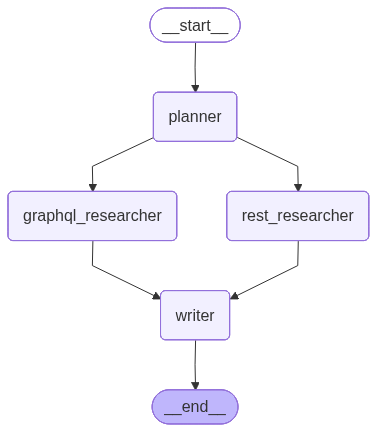

In [23]:
graph

In [24]:
# Run the Graph
user_task = "Write a short post comparing the pros of GraphQL with the cons of REST APIs and role of both in data aggregation ."
initial_state = {"task": user_task}

# Stream the events to see the execution flow
for event in graph.stream(initial_state):
    for key, value in event.items():
        print(f"Node '{key}' output:")
        print("---")
        print(value)
        print("\n" + "="*30 + "\n")

# Get the final output
final_state = graph.invoke(initial_state)
print("Final Comparison Post:")
print(final_state['final_output'])

PLANNER: Creating a plan for parallel execution
Node 'planner' output:
---
{'plan': ['Research GraphQL pros', 'Research REST cons', 'Write comparison post']}


GRAPHQL RESEARCHER: Searching for 'pros of GraphQL'
Node 'graphql_researcher' output:
---
{'graphql_results': 'GraphQL Pros: Efficient data fetching (no over-fetching), single endpoint, strongly typed schema.'}


REST RESEARCHER: Searching for 'cons of REST APIs'
Node 'rest_researcher' output:
---
{'rest_results': 'REST API Cons: Can lead to over or under-fetching data, requires multiple round-trips for complex queries, URL-based structure can be rigid.'}


WRITER: Synthesizing results
Node 'writer' output:
---
{'final_output': "## GraphQL vs. REST APIs: A Quick Comparison\n\nChoosing the right API architecture is crucial for modern web development. Both GraphQL and REST APIs offer solutions for data fetching, but they approach the problem in different ways. Here's a quick look at the strengths and weaknesses of each:\n\n**Graph